## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_2908-0309-2023.csv', firstRow=774, lastRow=780)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_290823_S775-780.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=56s and ended at t=476s; mass=44.0536g
This equals a volume of 44.142m; expected was 44.295mL; error is 0.345%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0015 g/s and for 2nd derivative = 0.0005625000000000001 g/s^2


<IPython.core.display.Javascript object>


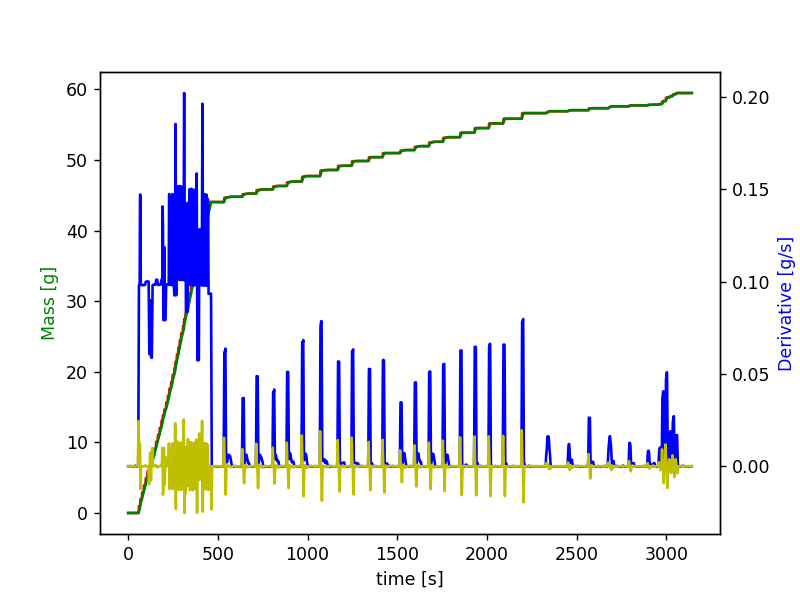

Addition of 0.755g Texapon SB 3 KC detected from 530s to 580s - expected volume = 0.989mL and actual volume = 0.684mL (resulting error is 30.878%)
Addition of 0.457g Plantapon LC 7 detected from 632s to 678s - expected volume = 0.602mL and actual volume = 0.432mL (resulting error is 28.135%)
Addition of 0.588g Plantapon LC 7 detected from 710s to 754s - expected volume = 0.602mL and actual volume = 0.557mL (resulting error is 7.427%)
Addition of 0.497g Plantacare 818 detected from 802s to 844s - expected volume = 0.596mL and actual volume = 0.46mL (resulting error is 22.873%)
Addition of 0.626g Plantacare 818 detected from 880s to 928s - expected volume = 0.596mL and actual volume = 0.579mL (resulting error is 2.764%)
Addition of 0.782g Plantacare 818 detected from 964s to 1002s - expected volume = 0.752mL and actual volume = 0.719mL (resulting error is 4.333%)
Addition of 0.865g Plantacare 2000 detected from 1066s to 1114s - expected volume = 0.941mL and actual volume = 0.8mL (resulti

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.000546875 g/s^2


<IPython.core.display.Javascript object>


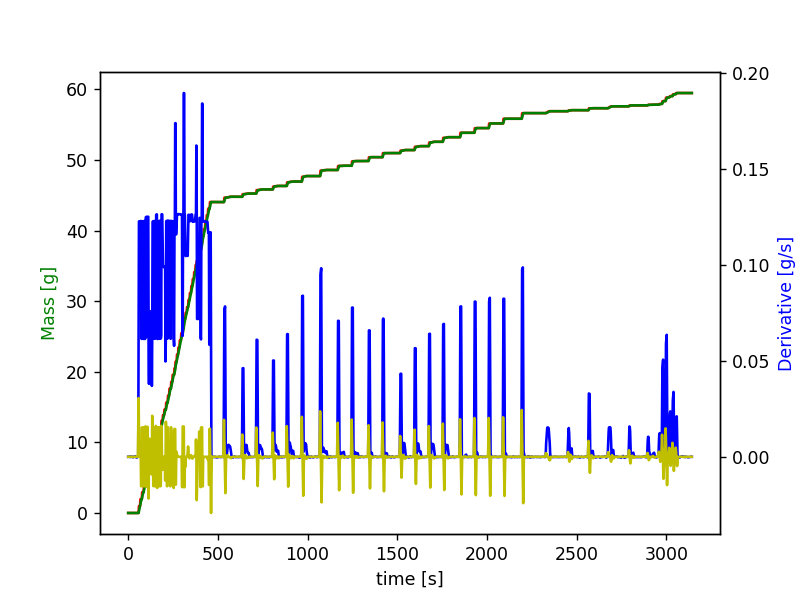

Addition of 0.275g Dehyquart CC7 Benz detected from 2324s to 2358s - expected volume = 0.296mL and actual volume = 0.273mL (resulting error is 7.985%)
Addition of 0.154g Dehyquart CC7 Benz detected from 2446s to 2480s - expected volume = 0.131mL and actual volume = 0.151mL (resulting error is 15.602%)
Addition of 0.283g Dehyquart CC7 Benz detected from 2562s to 2596s - expected volume = 0.268mL and actual volume = 0.282mL (resulting error is 5.251%)
Addition of 0.272g Dehyquart CC7 Benz detected from 2670s to 2710s - expected volume = 0.262mL and actual volume = 0.271mL (resulting error is 3.279%)
Addition of 0.14g Dehyquart CC7 Benz detected from 2788s to 2820s - expected volume = 0.134mL and actual volume = 0.139mL (resulting error is 3.796%)
Addition of 0.094g Dehyquart CC7 Benz detected from 2890s to 2914s - expected volume = 0.103mL and actual volume = 0.093mL (resulting error is 9.615%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2152,2256,2366,2482,2582,2680,2758])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


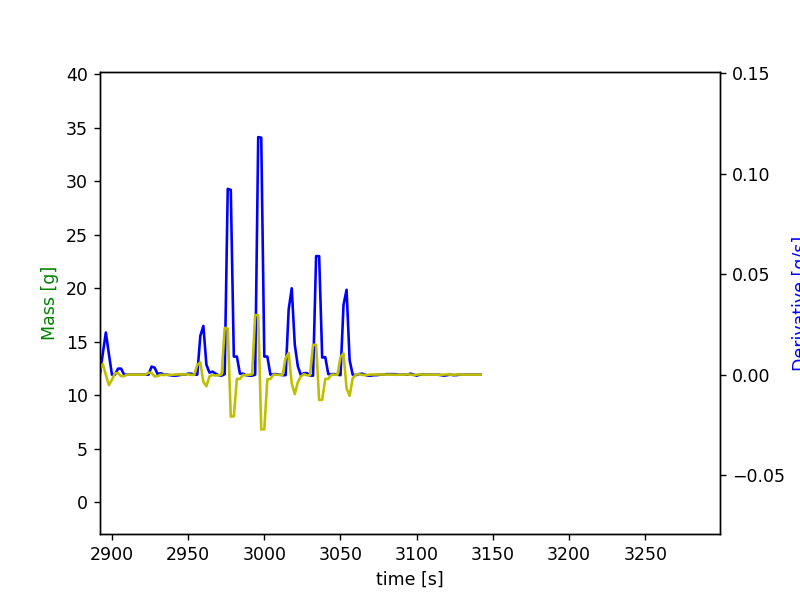

Addition of 0.103g Arlypon TT detected from 2954s to 2966s - expected volume = 0.113mL and actual volume = 0.108mL (resulting error is 4.63%)
Addition of 0.405g Arlypon TT detected from 2972s to 2988s - expected volume = 0.465mL and actual volume = 0.421mL (resulting error is 9.487%)
Addition of 0.508g Arlypon TT detected from 2992s to 3008s - expected volume = 0.525mL and actual volume = 0.534mL (resulting error is 1.703%)
Addition of 0.19g Arlypon TT detected from 3012s to 3026s - expected volume = 0.134mL and actual volume = 0.199mL (resulting error is 49.213%)
Addition of 0.272g Arlypon TT detected from 3030s to 3046s - expected volume = 0.244mL and actual volume = 0.284mL (resulting error is 16.026%)
Addition of 0.168g Arlypon TT detected from 3048s to 3062s - expected volume = 0.132mL and actual volume = 0.176mL (resulting error is 33.73%)


In [5]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2490,2506,2522,2538,2554,2568,2588])

## Consolidate results and create output

In [6]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_290823_S775-S780.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_30088\2994544526.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
774,775.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,9.983125,0.0,13.036192,0.000000,0.0,0.0,0.0,2.781374,0.0,0.0,1.041278
775,776.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,11.206663,0.000000,0.0,0.000000,7.940914,0.0,0.0,0.0,1.530353,0.0,0.0,4.036150
776,777.0,0.000000,0.0,0.000000,11.170984,0.000000,12.739836,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,2.816622,0.0,0.0,5.048779
777,778.0,7.732137,0.0,0.000000,0.000000,8.849741,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,2.779936,0.0,0.0,1.939431
778,779.0,0.000000,0.0,10.481144,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.334623,0.000000,0.0,0.0,0.0,1.405426,0.0,0.0,2.723091
779,780.0,0.000000,0.0,0.000000,7.688472,0.000000,0.000000,0.000000,12.495735,0.0,0.000000,0.000000,0.0,0.0,0.0,0.924663,0.0,0.0,1.657507
